# Data Checks

Quick overview data checks and explorations for a session Treasure Hunt data.

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

# Import spike related utilities from spiketools
from spiketools.measures import compute_spike_rate
from spiketools.spatial.occupancy import compute_occupancy

from spiketools.plts.data import plot_bar, plot_hist
from spiketools.plts.space import plot_heatmap
from spiketools.plts.spikes import plot_unit_frs
from spiketools.plts.trials import plot_rasters

In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Set which task to analyze
task = 'THF'

In [5]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/' + task)

In [6]:
# Define subject information
subj = 'wv001'
session = 2

In [7]:
# Define bins to use
bins = [7, 21]

## Load NWB Data

In [8]:
# Define expected NWB file name & full path
file_name = '_'.join([subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [9]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

In [10]:
# Check the NWBfile contents
nwbfile

root pynwb.file.NWBFile at 0x140376103924976
Fields:
  acquisition: {
    chest_positions <class 'pynwb.behavior.Position'>,
    chest_trials <class 'pynwb.behavior.Position'>,
    position <class 'pynwb.behavior.Position'>,
    recall <class 'pynwb.behavior.Position'>
  }
  data_collection: West Virginia
  devices: {
    Microwire Electrodes <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    A-microwires-chnum <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: This file contains a recorded session of the Treasure Hunt task, a spatial-navigation memory task. The subject is a clinical patient with intractable epilepsy undergoing pre-surgical mapping in an epilepsy monitoring unit, with implants including Behnke-Fried microwires.
  experimenter: ['XX']
  file_create_date: [datetime.datetime(2021, 12, 16, 23, 5, 30, 10895, tzinfo=tzoffset(None, -18000))]
  identifier: XX
  institution: Columbia Un

## Position Data

In [11]:
# Extract the position data
pos = nwbfile.acquisition['position']['xy_position']
pos

xy_position pynwb.behavior.SpatialSeries at 0x140376105501552
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (2, 25761), type "<f8">
  description: XY position of the subject in the arena.
  interval: 1
  reference_frame: middle
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (25761,), type "<f8">
  timestamps_unit: seconds
  unit: meters

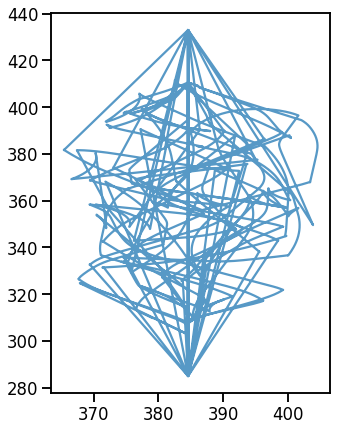

In [12]:
# Plot the map across all position traces
_, ax = plt.subplots(figsize=(5, 7))
ax.plot(*pos.data, alpha=0.75)

In [13]:
# Extract position data
x_data = pos.data[0, :]
y_data = pos.data[1, :]

In [14]:
# Check position ranges
print('x data range: {:6.2f} - {:6.2f}'.format(np.min(x_data), np.max(x_data)))
print('y data range: {:6.2f} - {:6.2f}'.format(np.min(y_data), np.max(y_data)))

x data range: 365.40 - 404.59
y data range: 285.00 - 433.00


In [15]:
# Get speed
speed = nwbfile.processing['position_measures']['speed'].data[:]

## Occupancy

In [16]:
# Compute occupancy values
occ = compute_occupancy(pos.data[:], pos.timestamps[:], bins, speed, set_nan=True)

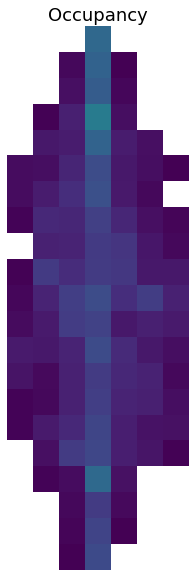

In [17]:
# Plot the occupancy
plot_heatmap(occ, transpose=True, title="Occupancy", vmax=25, figsize=(10, 10))

## Stimuli

In [18]:
# Collect chest positions
chest_pos = nwbfile.acquisition['chest_positions']
chest_xs, chest_ys = chest_pos['chest_positions'].data[:]

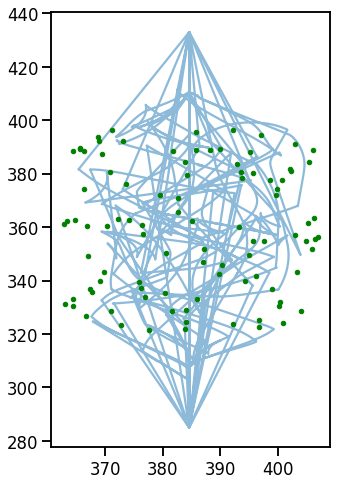

In [19]:
# Plot the subject positions, overlaid with chest positions
#   Note: update this to use plot_positions
_, ax = plt.subplots(figsize=(5, 8))
ax.plot(*pos.data[:], alpha=0.5)
ax.plot(chest_xs, chest_ys, '.g');

In [20]:
# Collect and check which trial each trial is in
chest_trials = nwbfile.acquisition['chest_trials']
chest_trials = chest_trials['chest_trials'].data[:]
chest_trials

array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
        4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
        8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
       12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16,
       17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21,
       21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23])

#### Recall Selector

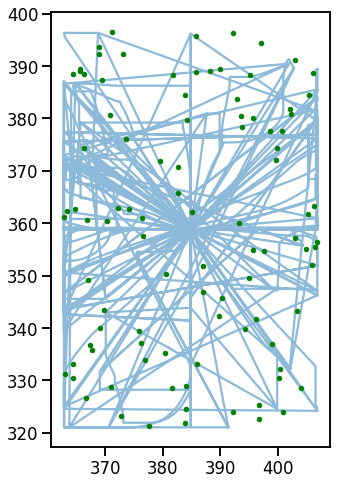

In [21]:
# Plot the positions of the recall selector, overlaid with chest positions
#   Note: update this to use plot_positions
_, ax = plt.subplots(figsize=(5, 8))
ax.plot(*nwbfile.acquisition['recall']['selector'].data[:], alpha=0.5)
ax.plot(chest_xs, chest_ys, '.g');

## Trials

In [22]:
# Check the data available in the NWB trials section
nwbfile.trials

trials pynwb.epoch.TimeIntervals at 0x140376105500832
Fields:
  colnames: ['start_time' 'stop_time' 'chest_opening' 'confidence' 'correct'
 'distractor_end' 'distractor_start' 'encoding_end' 'encoding_start'
 'error' 'full_chest' 'num_chests' 'num_treasures' 'recall_end'
 'recall_start' 'response' 'stimulus']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    chest_opening_index <class 'hdmf.common.table.VectorIndex'>,
    chest_opening <class 'hdmf.common.table.VectorData'>,
    confidence_index <class 'hdmf.common.table.VectorIndex'>,
    confidence <class 'hdmf.common.table.VectorData'>,
    correct_index <class 'hdmf.common.table.VectorIndex'>,
    correct <class 'hdmf.common.table.VectorData'>,
    distractor_end <class 'hdmf.common.table.VectorData'>,
    distractor_start <class 'hdmf.common.table.VectorData'>,
    encoding_end <class 'hdmf.common.table.VectorData'>,
    encoding_start <class 'hdmf.common.

In [23]:
# Check the number of trials in the dataset
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 23


In [24]:
# Get the trial information as a dataframe
behav = nwbfile.trials.to_dataframe()
behav.head()

,start_time,stop_time,chest_opening,confidence,correct,distractor_end,distractor_start,encoding_end,encoding_start,error,full_chest,num_chests,num_treasures,recall_end,recall_start,response,stimulus
id,,,,,,,,,,,,,,,,,
0,1.623402e+12,1.623402e+12,"[1623402123200.8967, 1623402129135.9287, 16234...","[maybe, maybe, maybe]","[False, False, False]",1.623402e+12,1.623402e+12,1.623402e+12,1.623402e+12,"[45.73503750791073, 52.22430978098226, 55.4599...","[True, False, False, False]",4,3,1.623402e+12,1.623402e+12,"[1623402158561.0872, 1623402163941.1162, 16234...","[FacePlanePrefab, FacePlanePrefab, FacePlanePr..."
1,1.623402e+12,1.623402e+12,"[1623402188728.2498, 1623402196108.2896, 16234...","[maybe, maybe, maybe]","[False, False, False]",1.623402e+12,1.623402e+12,1.623402e+12,1.623402e+12,"[32.423174423396574, 34.150836314796145, 36.51...","[False, False, True, False]",4,3,1.623402e+12,1.623402e+12,"[1623402226352.4526, 1623402230192.4734, 16234...","[FacePlanePrefab, FacePlanePrefab, FacePlanePr..."
2,1.623402e+12,1.623402e+12,"[1623402260721.638, 1623402264776.66, 16234022...","[maybe, maybe]","[False, False]",1.623402e+12,1.623402e+12,1.623402e+12,1.623402e+12,"[14.604033802343807, 15.834481971318136]","[False, False, True, True]",4,2,1.623402e+12,1.623402e+12,"[1623402291841.8057, 1623402298873.8438]","[FacePlanePrefab, FacePlanePrefab]"
3,1.623402e+12,1.623402e+12,"[1623402313127.9204, 1623402317564.9443, 16234...","[maybe, maybe]","[True, False]",1.623402e+12,1.623402e+12,1.623402e+12,1.623402e+12,"[3.516259944884664, 22.22750061815316]","[True, False, False, True]",4,2,1.623402e+12,1.623402e+12,"[1623402345157.0933, 1623402352364.132]","[FacePlanePrefab, FacePlanePrefab]"
4,1.623402e+12,1.623402e+12,"[1623402364701.1985, 1623402368542.2192, 16234...","[maybe, maybe, maybe]","[True, True, True]",1.623402e+12,1.623402e+12,1.623402e+12,1.623402e+12,"[10.951025670684906, 8.672983876383018, 6.6770...","[True, False, False, False]",4,3,1.623402e+12,1.623402e+12,"[1623402396682.3708, 1623402400313.3906, 16234...","[FacePlanePrefab, FacePlanePrefab, FacePlanePr..."


#### Confidence

In [25]:
# Count confidence answers
conf_counts = Counter(nwbfile.trials.confidence.data[:])

In [26]:
# Fix confidence answers
for el in ['yes', 'maybe', 'no']:
    if el not in conf_counts:
        conf_counts[el] = 0

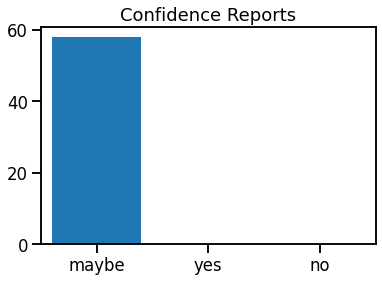

In [27]:
# Plot confidence answers
plot_bar(conf_counts.values(), conf_counts.keys(), title='Confidence Reports')

#### Response Error

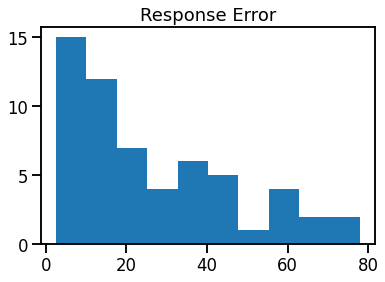

In [28]:
# Plot response error
plot_hist(nwbfile.trials.error.data[:], title='Response Error')

## Check Unit Data

In [29]:
# Check the data available in the NWB units section
nwbfile.units

units pynwb.misc.Units at 0x140376105631904
Fields:
  colnames: ['channel' 'location' 'cluster' 'spike_times' 'electrodes']
  columns: (
    channel <class 'hdmf.common.table.VectorData'>,
    location <class 'hdmf.common.table.VectorData'>,
    cluster <class 'hdmf.common.table.VectorData'>,
    spike_times_index <class 'hdmf.common.table.VectorIndex'>,
    spike_times <class 'hdmf.common.table.VectorData'>,
    electrodes_index <class 'hdmf.common.table.VectorIndex'>,
    electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  )
  description: Spike sorting solutions - done with oSort by Runnan Cao.
  id: id <class 'hdmf.common.table.ElementIdentifiers'>
  waveform_unit: volts

In [30]:
# Check how many units are available
n_units = len(nwbfile.units)
print('Number of units: {}'.format(n_units))

Number of units: 81


In [31]:
# Check the total number of spikes
print('Total number of spikes: {}'.format(nwbfile.units.spike_times.shape[0]))

Total number of spikes: 311316


In [32]:
# Calculate the average overall firing rate of each neuron
rates = [compute_spike_rate(nwbfile.units.get_unit_spike_times(s_ind) / 1000000) \
         for s_ind in range(n_units)]

In [33]:
# Count the number of units per wire
channel_counts = Counter(nwbfile.units.channel[:])
counts_per_wire = Counter(channel_counts.values())

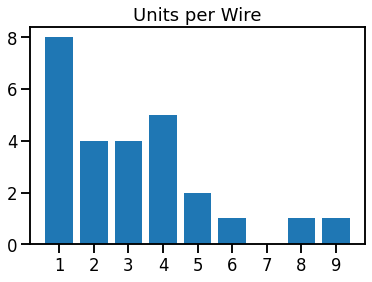

In [34]:
# Plot the distribution of units per wire
plt.bar(counts_per_wire.keys(), counts_per_wire.values())
plt.xticks(list(range(min(counts_per_wire.keys()), max(counts_per_wire.keys()) + 1)));
plt.title('Units per Wire');

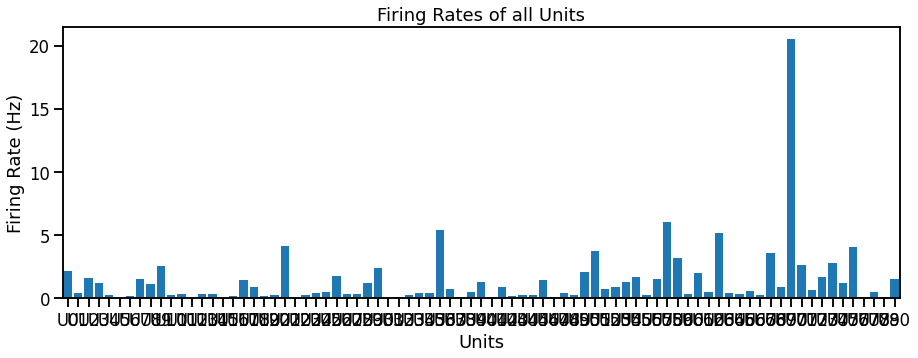

In [35]:
# Plot approximate firing rate for each unit
plot_unit_frs(rates, figsize=(15, 5))

In [36]:
# Get the time range of spike activity
first_spike = np.min(nwbfile.units.spike_times[:])
last_spike = np.max(nwbfile.units.spike_times[:])
dur = last_spike - first_spike

In [37]:
# Collect session normalized spiking activity across all units
all_spikes = []
for uind in range(n_units):
    spikes = nwbfile.units.get_unit_spike_times(uind)# - first_spike
    all_spikes.append(spikes / 1000)

In [38]:
st, en = nwbfile.trials.start_time[0], nwbfile.trials.stop_time[-1]

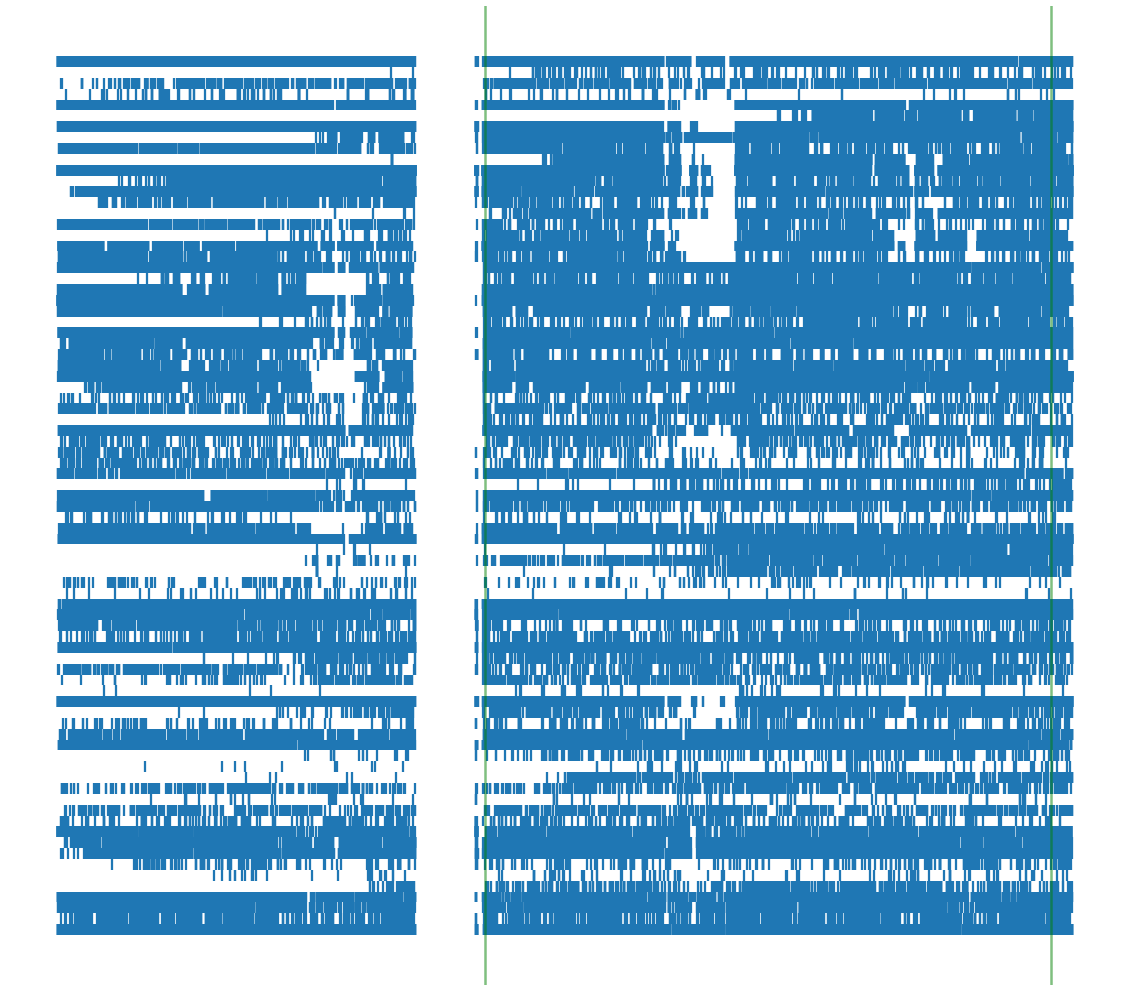

In [39]:
# Plot the session-level raster plot across all units together
plot_rasters(all_spikes, vline=[st, en], figsize=(20, 18),
             #xlim=[0, dur/1000], ylim=[-1, 81]
            )

In [40]:
# # Print out the whole-session spike raster for each neuron separately
# for uind in range(n_units):
#     spikes = nwbfile.units.get_unit_spike_times(uind) - first_spike
#     plt.figure()
#     plt.eventplot(spikes / 1000)
#     plt.xlim(0, dur/1000)